### Quick figure generation for NSF Preproposal
Data exploration of a chunk or Oregon encompassing Crater Lake State Park.
General workflow: 
1. Grab terrain model for the area
2. Run a watershed analysis, including generation of Slope and Aspect rasters
3. Run a solar insolation model, including topographic shading effects
4. Analyze the output in the context of a timeseries of NDVI slopes derived from the Landsat archive

In [262]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr

# Curve fitting and linear models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy # R-esque version of formula declaration


wrkDir = 'C:/Users/krofc_000/Desktop/NSF_Preoproposal_Figure/'

#### Snag the functions from the Osceola work to read in and display rasters quickly

In [2]:
def importRaster(rasterPath, **kwargs):
    # Open and read in the raster as an array
    raster_ds = gdal.Open(rasterPath)
    rastermap = raster_ds.ReadAsArray()
    
    # Set the default data type to 'float'
    if 'dtype' not in kwargs:
        dtype = 'float'
    rastermap = rastermap.astype(dtype)
    
    # If specified, set the no data value to NaN
    if 'noData' in kwargs:
        rastermap[rastermap == noData] = np.nan
    return rastermap

def plotRaster(image, ax=None, *args, **kwargs):

    # Grab figure axes if none stated
    if ax == None:
         ax = plt.gca()
                   
    # Normalize color scheme
    if 'norm' not in kwargs:
        vmin = kwargs.pop('vmin', None)
        vmax = kwargs.pop('vmax', None)
        if vmin is None:
            vmin = np.min(image) # or what ever
        if vmax is None:
            vmax = np.max(image)
        norm = matplotlib.colors.Normalize(vmin, vmax)
        kwargs['norm'] = norm

    #ax.figure.canvas.draw() # if you want to force a re-draw
    ax.imshow(image, *args, **kwargs)
    # Setup axes
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

#### Read in subset and reprojected rasters

In [193]:
DEM = importRaster(wrkDir + 'CraterLake_DEM.tif')
Aspect = importRaster(wrkDir + 'CraterLake_Aspect_5070_30m.tif')
SNDVI = importRaster(wrkDir + 'CraterLake_SNDVI_5070.tif')
landTrendr = importRaster(wrkDir + 'LandTrendr_5070_clip.tif')
globalRad = importRaster(wrkDir + 'CraterLake_RG.tif')

#### Quickly visualize each raster layer

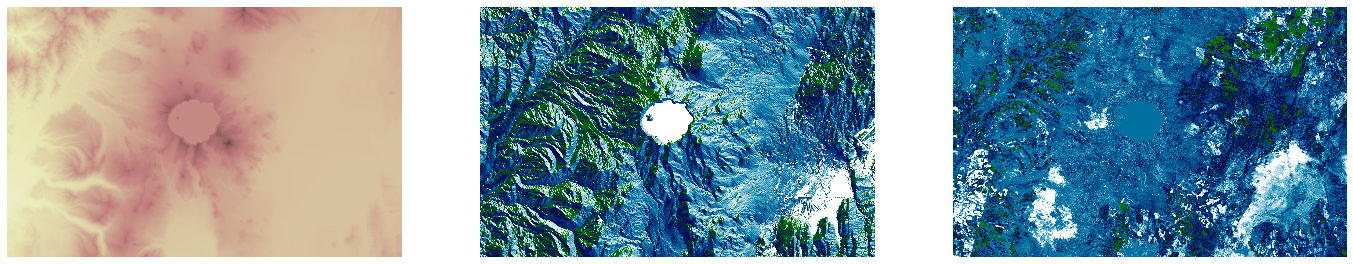

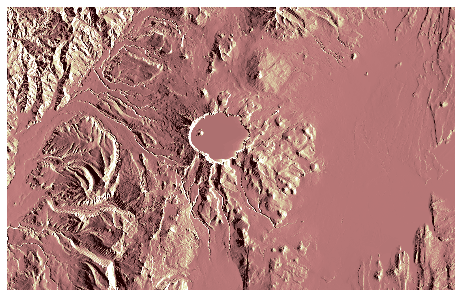

In [196]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (24,10))
# Extents grabbed from min and max raster values, excluding no data values (derived in QGIS)
plotRaster(DEM, ax = ax1, cmap = 'pink_r', vmin = 200, vmax = 3000)
plotRaster(Aspect, ax = ax2, cmap = 'ocean_r', vmin = 9, vmax = 350)
plotRaster(SNDVI, ax = ax3, cmap = 'ocean_r', vmin = -.007, vmax = .012)

f, (ax4) = plt.subplots(1,1, figsize = (8,8))
plotRaster(globalRad, ax = ax4, cmap = 'pink_r', vmin = 4000, vmax = 7000)


#### Reclassify Aspect raster
We want to bin everything north and south facing into discrete bins. I'll just make two specific bins, with everything else masked out. North will range from 315 to 45 degrees, South will range from 135 to 225 degrees.

Start by raveling the data into a pandas dataframe, for convenience.

In [274]:
craterLake = pd.DataFrame(dict(elev = DEM.ravel(), aspect = Aspect.ravel(), 
                               delndvi = SNDVI.ravel(), dist = landTrendr.ravel(),
                              rG = globalRad.ravel()))


### Analyze a subset of the data, thats topographically interesting
and look for patterns in topography and rG that may relate to the trend in NDVI

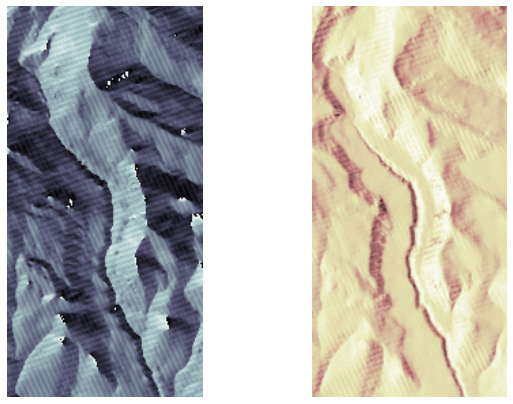

In [281]:
aspectSub = importRaster(wrkDir + 'AspectClip.tif')
rG_sub = importRaster(wrkDir + 'ExtractedRidge.tif')

f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,7))
# Extents grabbed from min and max raster values, excluding no data values (derived in QGIS)
plotRaster(aspectSub, ax = ax1, cmap = 'bone')
plotRaster(rG_sub, ax = ax2, cmap = 'pink')


#### Within this subset
create a distribution of total radiation binned by aspect

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


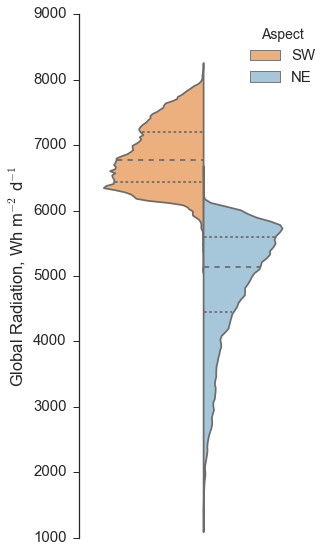

In [351]:
subdata = pd.DataFrame(dict(aspect = aspectSub.ravel(), rG = rG_sub.ravel()))
subdata['total'] = 'All'
subdata['Aspect'] = 'Other'
subdata.Aspect[(subdata.aspect > 200) & (subdata.aspect <= 275)] = 'SW'
subdata.Aspect[(subdata.aspect > 45) & (subdata.aspect <= 120)] = 'NE'

NWSE = subdata[subdata.Aspect != 'Other']

fig, ax1 = plt.subplots(1,1, figsize = (5,8))
sns.violinplot(y = 'rG', x = 'total', hue = 'Aspect',
               data = NWSE, split = True, bw=.05, inner="quartile",
              palette = ['#fdae6b','#9ecae1'])
sns.set_context('notebook', font_scale = 1.5)
plt.ylabel('Global Radiation, Wh m$^{-2}$ d$^{-1}$')
plt.xlabel('')
ax1.set_xticklabels([''])
ax1.set_xticks([])
sns.despine(bottom = True)
plt.tight_layout()
plt.savefig(wrkDir + 'rG_Dist.tif')

### For a subset of three small subplots
query the radiation values that correspond to vegetation increases and decreases. This is all done in QGIS manually in a one-off sort of way.

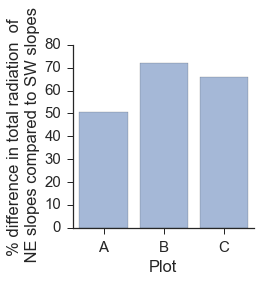

In [360]:
westLabel = [3000, 5915] 
eastLabel = [5301, 7370] 
northLabel = [5206, 7892]
#print westLabel, eastLabel, northLabel

objects = ['A','B','C']
y_pos = np.arange(len(objects))
performance = [westLabel, eastLabel, northLabel]
plt.figure(figsize = (4,4))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('% difference in total radiation  of\n NE slopes compared to SW slopes')
plt.xlabel('Plot')
sns.despine()
plt.tight_layout()
plt.savefig(wrkDir + 'radBar.tif')

#### Consider groubing the barchart by aspect
and plotting the absolute radiation for each aspect and subplot on the y-axis. Finally, change the colors to match the increase or decrease of vegetation status from the NDVI slope map.

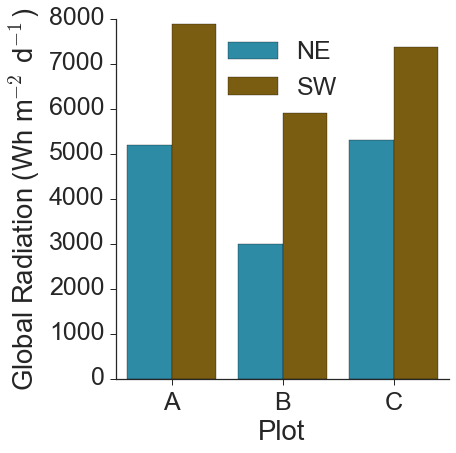

In [402]:
groubed_rG = pd.DataFrame(dict(Plot = ['A','B','C','A','B','C'], 
                               Aspect = ['NE','NE','NE', 'SW','SW','SW'],
                               rG = [5206, 3000, 5301,7892, 5915, 7370]))

plt.figure(figsize = (7,7))
sns.barplot(x = 'Plot',y = 'rG', hue='Aspect', 
            data = groubed_rG, palette = ['#1a96b9','#8d6500'])
plt.ylabel('Global Radiation (Wh m$^{-2}$ d$^{-1}$)')
sns.set_context('notebook', font_scale=2.5)
plt.legend(loc = 0)
sns.despine()
plt.tight_layout()
plt.savefig(wrkDir + 'radBars.tif')